Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
import csv
import torch.nn.functional as F

Setting up device

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Loading data

In [3]:
df = pd.read_csv("/kaggle/input/dataset/Multi-Label Text Classification Dataset.csv")
df = df.dropna()

Splitting data into train, validation and test data

In [4]:
train_dataset=df.sample(frac=0.7,random_state=200)

valid_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset=train_dataset.reset_index(drop=True)

test_dataset=valid_dataset.sample(frac=0.5,random_state=200)
valid_dataset=valid_dataset.drop(test_dataset.index).reset_index(drop=True)
test_dataset=test_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (49998, 20)
TRAIN Dataset: (34999, 20)
VALID Dataset: (7499, 20)
TEST Dataset: (7500, 20)


In [5]:
valid_data = valid_dataset[valid_dataset.columns[:6]].copy()
print(valid_data.head())
print(valid_data.shape)

                                               Title  \
0  [Identification of a functionally important di...   
1  Multilayer capsules: a promising microencapsul...   
2  Nanohydrogel with N,N'-bis(acryloyl)cystine cr...   
3  A new <i>Panolis</i> H?bner, [1821] species fr...   
4  Radiobiologic risk estimation from dental radi...   

                                        abstractText  \
0  The occurrence of individual amino acids and d...   
1  In 1980, Lim and Sun introduced a microcapsule...   
2  Substantially improved hydrogel particles base...   
3  Panolis is a well-defined and compact Palearct...   
4  The aim of the present study was to generate o...   

                                           meshMajor      pmid  \
0  ['Amino Acid Sequence', 'Analgesics, Opioid', ...  19060934   
1  ['Acrylic Resins', 'Alginates', 'Animals', 'Bi...  11426874   
2  ['Antineoplastic Agents', 'Cell Proliferation'...  28323099   
3  ['Animal Distribution', 'Animals', 'Asia', 'La...  28609947

Writing the train, validation and test data to csv file

In [6]:
file_path = '/kaggle/working/train_dataset.csv'
train_dataset.to_csv(file_path, index=False, header=True)

In [7]:
file_path = '/kaggle/working/valid_dataset.csv'
valid_dataset.to_csv(file_path, index=False, header=True)

In [8]:
file_path = '/kaggle/working/test_dataset.csv'
test_dataset.to_csv(file_path, index=False, header=True)

Combining the data in title and abstractText columns, and also the ground truth of all labels of a particular row to a list

In [9]:
train_dataset['list'] = train_dataset[train_dataset.columns[6:20]].values.tolist()

train_dataset['Combined'] = train_dataset['Title'].str.cat(train_dataset['abstractText'], sep=' ')

train_dataset = train_dataset[['Combined', 'list']].copy()

print(train_dataset.head())
print(train_dataset.shape)

                                            Combined  \
0  [Recommendations in relation to shift work]. T...   
1  Orbital venous approach to the cavernous sinus...   
2  Effects of cadmium on photosynthetic oxygen ev...   
3  Captopril in congestive heart failure: improve...   
4  Glycerol-induced development of catalytically ...   

                                         list  
0  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]  
1  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
2  [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
3  [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
4  [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
(34999, 2)


In [10]:
valid_dataset['list'] = valid_dataset[valid_dataset.columns[6:20]].values.tolist()

valid_dataset['Combined'] = valid_dataset['Title'].str.cat(valid_dataset['abstractText'], sep=' ')

valid_dataset = valid_dataset[['Combined', 'list']].copy()

print(valid_dataset.head())
print(valid_dataset.shape)

                                            Combined  \
0  [Identification of a functionally important di...   
1  Multilayer capsules: a promising microencapsul...   
2  Nanohydrogel with N,N'-bis(acryloyl)cystine cr...   
3  A new <i>Panolis</i> H?bner, [1821] species fr...   
4  Radiobiologic risk estimation from dental radi...   

                                         list  
0  [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]  
1  [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]  
2  [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]  
3  [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]  
4  [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]  
(7499, 2)


Setting up the learning parameters and importing tokenizer

In [11]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 1
EPOCHS = 20
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Defining dataset class

In [12]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = dataframe.Combined
        self.targets = dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
#             padding='max_length',
#             truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

Creating datasets

In [13]:
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

Setting up training and validation parameters, and making dataloaders

In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'drop_last': True
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'drop_last': True
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)

Defining the BERT neural network class

In [15]:
class BERTClass(torch.nn.Module):
    def __init__(self, fine_tune_layers=1):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 14)
        
        # Freeze all the parameters
        for param in self.l1.parameters():
            param.requires_grad = False

        # Unfreeze the top n layers
        if fine_tune_layers > 0:
            for layer in self.l1.encoder.layer[-fine_tune_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

Creating the model

In [16]:
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Defining loss function as Binary Cross Entropy with Logits Loss 

In [17]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

Defining Adam optimizer

In [18]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Defining evaluation function

In [19]:
def evaluate(data_loader, valid_data):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            if(i%1000==0):
                print("Data No.:",i)
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            total_loss+=loss.data.item()
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    total_loss = total_loss/(len(data_loader))

    fin_outputs = np.array(fin_outputs) >= 0.5
    
    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    print('accuracy:', accuracy)
    
    target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']    
    print(metrics.classification_report(fin_targets, fin_outputs, target_names=target_names))
    
    precision = metrics.precision_score(fin_targets, fin_outputs, average=None)
    precision_micro = metrics.precision_score(fin_targets, fin_outputs, average='micro')
    precision_macro = metrics.precision_score(fin_targets, fin_outputs, average='macro')
    
    recall = metrics.recall_score(fin_targets, fin_outputs, average=None)
    recall_micro = metrics.recall_score(fin_targets, fin_outputs, average='micro')
    recall_macro = metrics.recall_score(fin_targets, fin_outputs, average='macro')
    
    f1_score = metrics.f1_score(fin_targets, fin_outputs, average=None)
    f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')
    
    fin_outputs = fin_outputs.astype(int)

    new_df = pd.DataFrame(fin_outputs, columns=target_names)

    inference = pd.concat([valid_data, new_df], axis=1)

    file_path = '/kaggle/working/valid_inference.csv'
    inference.to_csv(file_path, index=False, header=True)
    
    return total_loss, accuracy, precision, precision_micro, precision_macro, recall, recall_micro, recall_macro, f1_score, f1_score_micro, f1_score_macro

Defining training function

In [20]:
def train(epoch):
    model.train()
    epoch_train_loss = 0
    for batch_num,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if(batch_num%100==0):
            print(f'Epoch: {epoch}, Batch_Num: {batch_num}, Batch_Loss: {loss.data.item()}')
        epoch_train_loss+=loss.data.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         break
    epoch_train_loss = epoch_train_loss/(len(training_loader))
    valid_loss, accuracy, precision, precision_micro, precision_macro, recall, recall_micro, recall_macro, f1_score, f1_score_micro, f1_score_macro = evaluate(validation_loader, valid_data)
    return epoch_train_loss, valid_loss, accuracy, precision, precision_micro, precision_macro, recall, recall_micro, recall_macro, f1_score, f1_score_micro, f1_score_macro

Training loop

In [21]:
train_loss_list = []
valid_loss_list = []
accuracy_list = []
precision_list = []
precision_micro_list = []
precision_macro_list = []
recall_list = []
recall_micro_list = []
recall_macro_list = []
f1_score_list = []
f1_score_micro_list = []
f1_score_macro_list = []

for epoch in range(EPOCHS):
    epoch_train_loss, valid_loss, accuracy, precision, precision_micro, precision_macro, recall, recall_micro, recall_macro, f1_score, f1_score_micro, f1_score_macro = train(epoch)
    print(f'Epoch: {epoch}, Train_Loss: {epoch_train_loss}, Valid_Loss: {valid_loss}')
    train_loss_list.append(epoch_train_loss)
    valid_loss_list.append(valid_loss)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    precision_micro_list.append(precision_micro)
    precision_macro_list.append(precision_macro)
    recall_list.append(recall)
    recall_micro_list.append(recall_micro)
    recall_macro_list.append(recall_macro)
    f1_score_list.append(f1_score)
    f1_score_micro_list.append(f1_score_micro)
    f1_score_macro_list.append(f1_score_macro)
#     break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Batch_Num: 0, Batch_Loss: 0.6763616800308228
Epoch: 0, Batch_Num: 100, Batch_Loss: 0.5192564725875854
Epoch: 0, Batch_Num: 200, Batch_Loss: 0.48997774720191956
Epoch: 0, Batch_Num: 300, Batch_Loss: 0.4896693229675293
Epoch: 0, Batch_Num: 400, Batch_Loss: 0.44961053133010864
Epoch: 0, Batch_Num: 500, Batch_Loss: 0.44241517782211304
Epoch: 0, Batch_Num: 600, Batch_Loss: 0.4242211878299713
Epoch: 0, Batch_Num: 700, Batch_Loss: 0.3690536320209503
Epoch: 0, Batch_Num: 800, Batch_Loss: 0.4815064072608948
Epoch: 0, Batch_Num: 900, Batch_Loss: 0.33185911178588867
Epoch: 0, Batch_Num: 1000, Batch_Loss: 0.42886170744895935
Epoch: 0, Batch_Num: 1100, Batch_Loss: 0.3078400194644928
Epoch: 0, Batch_Num: 1200, Batch_Loss: 0.37679392099380493
Epoch: 0, Batch_Num: 1300, Batch_Loss: 0.4013310372829437
Epoch: 0, Batch_Num: 1400, Batch_Loss: 0.3879273235797882
Epoch: 0, Batch_Num: 1500, Batch_Loss: 0.357032835483551
Epoch: 0, Batch_Num: 1600, Batch_Loss: 0.4090721309185028
Epoch: 0, Batch_Num: 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0, Train_Loss: 0.41211202661632457, Valid_Loss: 0.3482033712887529


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 1, Batch_Num: 0, Batch_Loss: 0.3548942506313324
Epoch: 1, Batch_Num: 100, Batch_Loss: 0.28891587257385254
Epoch: 1, Batch_Num: 200, Batch_Loss: 0.33115074038505554
Epoch: 1, Batch_Num: 300, Batch_Loss: 0.37237831950187683
Epoch: 1, Batch_Num: 400, Batch_Loss: 0.371169775724411
Epoch: 1, Batch_Num: 500, Batch_Loss: 0.3829209506511688
Epoch: 1, Batch_Num: 600, Batch_Loss: 0.3210467994213104
Epoch: 1, Batch_Num: 700, Batch_Loss: 0.2676332890987396
Epoch: 1, Batch_Num: 800, Batch_Loss: 0.43723735213279724
Epoch: 1, Batch_Num: 900, Batch_Loss: 0.2718580365180969
Epoch: 1, Batch_Num: 1000, Batch_Loss: 0.3896835446357727
Epoch: 1, Batch_Num: 1100, Batch_Loss: 0.26124587655067444
Epoch: 1, Batch_Num: 1200, Batch_Loss: 0.3284032940864563
Epoch: 1, Batch_Num: 1300, Batch_Loss: 0.37291795015335083
Epoch: 1, Batch_Num: 1400, Batch_Loss: 0.352507621049881
Epoch: 1, Batch_Num: 1500, Batch_Loss: 0.29955029487609863
Epoch: 1, Batch_Num: 1600, Batch_Loss: 0.35325372219085693
Epoch: 1, Batch_Num:

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1, Train_Loss: 0.3428528068828212, Valid_Loss: 0.3236345387582923


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 2, Batch_Num: 0, Batch_Loss: 0.3269753158092499
Epoch: 2, Batch_Num: 100, Batch_Loss: 0.26516589522361755
Epoch: 2, Batch_Num: 200, Batch_Loss: 0.30993327498435974
Epoch: 2, Batch_Num: 300, Batch_Loss: 0.3475642502307892
Epoch: 2, Batch_Num: 400, Batch_Loss: 0.3371475338935852
Epoch: 2, Batch_Num: 500, Batch_Loss: 0.38561883568763733
Epoch: 2, Batch_Num: 600, Batch_Loss: 0.2846117615699768
Epoch: 2, Batch_Num: 700, Batch_Loss: 0.25098392367362976
Epoch: 2, Batch_Num: 800, Batch_Loss: 0.39008089900016785
Epoch: 2, Batch_Num: 900, Batch_Loss: 0.2561921775341034
Epoch: 2, Batch_Num: 1000, Batch_Loss: 0.379605233669281
Epoch: 2, Batch_Num: 1100, Batch_Loss: 0.2489616870880127
Epoch: 2, Batch_Num: 1200, Batch_Loss: 0.3250151574611664
Epoch: 2, Batch_Num: 1300, Batch_Loss: 0.347385436296463
Epoch: 2, Batch_Num: 1400, Batch_Loss: 0.3240152597427368
Epoch: 2, Batch_Num: 1500, Batch_Loss: 0.31855183839797974
Epoch: 2, Batch_Num: 1600, Batch_Loss: 0.34611377120018005
Epoch: 2, Batch_Num: 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2, Train_Loss: 0.3233055061995847, Valid_Loss: 0.3101985279795074


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 3, Batch_Num: 0, Batch_Loss: 0.3155396580696106
Epoch: 3, Batch_Num: 100, Batch_Loss: 0.26318785548210144
Epoch: 3, Batch_Num: 200, Batch_Loss: 0.286037415266037
Epoch: 3, Batch_Num: 300, Batch_Loss: 0.316598117351532
Epoch: 3, Batch_Num: 400, Batch_Loss: 0.3278700113296509
Epoch: 3, Batch_Num: 500, Batch_Loss: 0.36271950602531433
Epoch: 3, Batch_Num: 600, Batch_Loss: 0.2637518048286438
Epoch: 3, Batch_Num: 700, Batch_Loss: 0.23541423678398132
Epoch: 3, Batch_Num: 800, Batch_Loss: 0.3786850869655609
Epoch: 3, Batch_Num: 900, Batch_Loss: 0.25312885642051697
Epoch: 3, Batch_Num: 1000, Batch_Loss: 0.3638182282447815
Epoch: 3, Batch_Num: 1100, Batch_Loss: 0.2267218977212906
Epoch: 3, Batch_Num: 1200, Batch_Loss: 0.3065679967403412
Epoch: 3, Batch_Num: 1300, Batch_Loss: 0.343037486076355
Epoch: 3, Batch_Num: 1400, Batch_Loss: 0.31272202730178833
Epoch: 3, Batch_Num: 1500, Batch_Loss: 0.2960797846317291
Epoch: 3, Batch_Num: 1600, Batch_Loss: 0.3298061490058899
Epoch: 3, Batch_Num: 170

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3, Train_Loss: 0.3120328566433362, Valid_Loss: 0.30304637258808553


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 4, Batch_Num: 0, Batch_Loss: 0.3245953619480133
Epoch: 4, Batch_Num: 100, Batch_Loss: 0.23653773963451385
Epoch: 4, Batch_Num: 200, Batch_Loss: 0.27237364649772644
Epoch: 4, Batch_Num: 300, Batch_Loss: 0.3108116090297699
Epoch: 4, Batch_Num: 400, Batch_Loss: 0.3321729600429535
Epoch: 4, Batch_Num: 500, Batch_Loss: 0.36301910877227783
Epoch: 4, Batch_Num: 600, Batch_Loss: 0.24487993121147156
Epoch: 4, Batch_Num: 700, Batch_Loss: 0.24131076037883759
Epoch: 4, Batch_Num: 800, Batch_Loss: 0.3737438917160034
Epoch: 4, Batch_Num: 900, Batch_Loss: 0.27591851353645325
Epoch: 4, Batch_Num: 1000, Batch_Loss: 0.3738115429878235
Epoch: 4, Batch_Num: 1100, Batch_Loss: 0.22092071175575256
Epoch: 4, Batch_Num: 1200, Batch_Loss: 0.3015856146812439
Epoch: 4, Batch_Num: 1300, Batch_Loss: 0.3248303532600403
Epoch: 4, Batch_Num: 1400, Batch_Loss: 0.32266637682914734
Epoch: 4, Batch_Num: 1500, Batch_Loss: 0.3111427426338196
Epoch: 4, Batch_Num: 1600, Batch_Loss: 0.32321852445602417
Epoch: 4, Batch_N

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4, Train_Loss: 0.30461032086984174, Valid_Loss: 0.29757593894196777


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 5, Batch_Num: 0, Batch_Loss: 0.31971675157546997
Epoch: 5, Batch_Num: 100, Batch_Loss: 0.23383864760398865
Epoch: 5, Batch_Num: 200, Batch_Loss: 0.284768283367157
Epoch: 5, Batch_Num: 300, Batch_Loss: 0.287638783454895
Epoch: 5, Batch_Num: 400, Batch_Loss: 0.32441410422325134
Epoch: 5, Batch_Num: 500, Batch_Loss: 0.3725942373275757
Epoch: 5, Batch_Num: 600, Batch_Loss: 0.25251883268356323
Epoch: 5, Batch_Num: 700, Batch_Loss: 0.2426411658525467
Epoch: 5, Batch_Num: 800, Batch_Loss: 0.35121551156044006
Epoch: 5, Batch_Num: 900, Batch_Loss: 0.2534479796886444
Epoch: 5, Batch_Num: 1000, Batch_Loss: 0.3582488000392914
Epoch: 5, Batch_Num: 1100, Batch_Loss: 0.22289802134037018
Epoch: 5, Batch_Num: 1200, Batch_Loss: 0.29731428623199463
Epoch: 5, Batch_Num: 1300, Batch_Loss: 0.3220473527908325
Epoch: 5, Batch_Num: 1400, Batch_Loss: 0.3126825988292694
Epoch: 5, Batch_Num: 1500, Batch_Loss: 0.3004792332649231
Epoch: 5, Batch_Num: 1600, Batch_Loss: 0.30531740188598633
Epoch: 5, Batch_Num:

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5, Train_Loss: 0.2982838449000658, Valid_Loss: 0.2930850260653191


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 6, Batch_Num: 0, Batch_Loss: 0.31685662269592285
Epoch: 6, Batch_Num: 100, Batch_Loss: 0.24201366305351257
Epoch: 6, Batch_Num: 200, Batch_Loss: 0.2696993947029114
Epoch: 6, Batch_Num: 300, Batch_Loss: 0.2903095781803131
Epoch: 6, Batch_Num: 400, Batch_Loss: 0.2986624836921692
Epoch: 6, Batch_Num: 500, Batch_Loss: 0.35459309816360474
Epoch: 6, Batch_Num: 600, Batch_Loss: 0.23948892951011658
Epoch: 6, Batch_Num: 700, Batch_Loss: 0.2390478551387787
Epoch: 6, Batch_Num: 800, Batch_Loss: 0.34807369112968445
Epoch: 6, Batch_Num: 900, Batch_Loss: 0.24419718980789185
Epoch: 6, Batch_Num: 1000, Batch_Loss: 0.3459097445011139
Epoch: 6, Batch_Num: 1100, Batch_Loss: 0.20777259767055511
Epoch: 6, Batch_Num: 1200, Batch_Loss: 0.27782270312309265
Epoch: 6, Batch_Num: 1300, Batch_Loss: 0.3187495768070221
Epoch: 6, Batch_Num: 1400, Batch_Loss: 0.3127714693546295
Epoch: 6, Batch_Num: 1500, Batch_Loss: 0.29285651445388794
Epoch: 6, Batch_Num: 1600, Batch_Loss: 0.30580854415893555
Epoch: 6, Batch_

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6, Train_Loss: 0.2932980813198456, Valid_Loss: 0.2892856311864266


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 7, Batch_Num: 0, Batch_Loss: 0.3179382085800171
Epoch: 7, Batch_Num: 100, Batch_Loss: 0.22802996635437012
Epoch: 7, Batch_Num: 200, Batch_Loss: 0.2691044807434082
Epoch: 7, Batch_Num: 300, Batch_Loss: 0.29255127906799316
Epoch: 7, Batch_Num: 400, Batch_Loss: 0.31246626377105713
Epoch: 7, Batch_Num: 500, Batch_Loss: 0.3473997414112091
Epoch: 7, Batch_Num: 600, Batch_Loss: 0.24950912594795227
Epoch: 7, Batch_Num: 700, Batch_Loss: 0.21294161677360535
Epoch: 7, Batch_Num: 800, Batch_Loss: 0.34269171953201294
Epoch: 7, Batch_Num: 900, Batch_Loss: 0.24818003177642822
Epoch: 7, Batch_Num: 1000, Batch_Loss: 0.3346494436264038
Epoch: 7, Batch_Num: 1100, Batch_Loss: 0.20529809594154358
Epoch: 7, Batch_Num: 1200, Batch_Loss: 0.2950829863548279
Epoch: 7, Batch_Num: 1300, Batch_Loss: 0.3065476417541504
Epoch: 7, Batch_Num: 1400, Batch_Loss: 0.3109816610813141
Epoch: 7, Batch_Num: 1500, Batch_Loss: 0.27982497215270996
Epoch: 7, Batch_Num: 1600, Batch_Loss: 0.3015855550765991
Epoch: 7, Batch_N

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7, Train_Loss: 0.28900662576247416, Valid_Loss: 0.2863923060160181


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 8, Batch_Num: 0, Batch_Loss: 0.30659499764442444
Epoch: 8, Batch_Num: 100, Batch_Loss: 0.23946969211101532
Epoch: 8, Batch_Num: 200, Batch_Loss: 0.2732848525047302
Epoch: 8, Batch_Num: 300, Batch_Loss: 0.2689772844314575
Epoch: 8, Batch_Num: 400, Batch_Loss: 0.3189352750778198
Epoch: 8, Batch_Num: 500, Batch_Loss: 0.3466152846813202
Epoch: 8, Batch_Num: 600, Batch_Loss: 0.22467690706253052
Epoch: 8, Batch_Num: 700, Batch_Loss: 0.22883737087249756
Epoch: 8, Batch_Num: 800, Batch_Loss: 0.33804813027381897
Epoch: 8, Batch_Num: 900, Batch_Loss: 0.26204967498779297
Epoch: 8, Batch_Num: 1000, Batch_Loss: 0.34078449010849
Epoch: 8, Batch_Num: 1100, Batch_Loss: 0.196165531873703
Epoch: 8, Batch_Num: 1200, Batch_Loss: 0.27062568068504333
Epoch: 8, Batch_Num: 1300, Batch_Loss: 0.31944575905799866
Epoch: 8, Batch_Num: 1400, Batch_Loss: 0.2900269031524658
Epoch: 8, Batch_Num: 1500, Batch_Loss: 0.275047242641449
Epoch: 8, Batch_Num: 1600, Batch_Loss: 0.2827517092227936
Epoch: 8, Batch_Num: 1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8, Train_Loss: 0.28527658696745867, Valid_Loss: 0.28414246939139565


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 9, Batch_Num: 0, Batch_Loss: 0.31441599130630493
Epoch: 9, Batch_Num: 100, Batch_Loss: 0.2230120450258255
Epoch: 9, Batch_Num: 200, Batch_Loss: 0.26405662298202515
Epoch: 9, Batch_Num: 300, Batch_Loss: 0.26008689403533936
Epoch: 9, Batch_Num: 400, Batch_Loss: 0.2992619276046753
Epoch: 9, Batch_Num: 500, Batch_Loss: 0.3442371189594269
Epoch: 9, Batch_Num: 600, Batch_Loss: 0.20739151537418365
Epoch: 9, Batch_Num: 700, Batch_Loss: 0.23938550055027008
Epoch: 9, Batch_Num: 800, Batch_Loss: 0.32816147804260254
Epoch: 9, Batch_Num: 900, Batch_Loss: 0.2552191913127899
Epoch: 9, Batch_Num: 1000, Batch_Loss: 0.3209834098815918
Epoch: 9, Batch_Num: 1100, Batch_Loss: 0.19701488316059113
Epoch: 9, Batch_Num: 1200, Batch_Loss: 0.27819886803627014
Epoch: 9, Batch_Num: 1300, Batch_Loss: 0.2891576290130615
Epoch: 9, Batch_Num: 1400, Batch_Loss: 0.2952970862388611
Epoch: 9, Batch_Num: 1500, Batch_Loss: 0.28323230147361755
Epoch: 9, Batch_Num: 1600, Batch_Loss: 0.2888944745063782
Epoch: 9, Batch_N

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9, Train_Loss: 0.2820456159553628, Valid_Loss: 0.2822799079869291


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 10, Batch_Num: 0, Batch_Loss: 0.3102983832359314
Epoch: 10, Batch_Num: 100, Batch_Loss: 0.2387629747390747
Epoch: 10, Batch_Num: 200, Batch_Loss: 0.25143733620643616
Epoch: 10, Batch_Num: 300, Batch_Loss: 0.2654954195022583
Epoch: 10, Batch_Num: 400, Batch_Loss: 0.3002101480960846
Epoch: 10, Batch_Num: 500, Batch_Loss: 0.3322685956954956
Epoch: 10, Batch_Num: 600, Batch_Loss: 0.20772093534469604
Epoch: 10, Batch_Num: 700, Batch_Loss: 0.2216048687696457
Epoch: 10, Batch_Num: 800, Batch_Loss: 0.33531543612480164
Epoch: 10, Batch_Num: 900, Batch_Loss: 0.23943939805030823
Epoch: 10, Batch_Num: 1000, Batch_Loss: 0.3088073134422302
Epoch: 10, Batch_Num: 1100, Batch_Loss: 0.18786686658859253
Epoch: 10, Batch_Num: 1200, Batch_Loss: 0.27608609199523926
Epoch: 10, Batch_Num: 1300, Batch_Loss: 0.2973155677318573
Epoch: 10, Batch_Num: 1400, Batch_Loss: 0.3111051023006439
Epoch: 10, Batch_Num: 1500, Batch_Loss: 0.286847323179245
Epoch: 10, Batch_Num: 1600, Batch_Loss: 0.2899106740951538
Epoc

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10, Train_Loss: 0.27907210621841433, Valid_Loss: 0.2805860572026235


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 11, Batch_Num: 0, Batch_Loss: 0.30372804403305054
Epoch: 11, Batch_Num: 100, Batch_Loss: 0.2215721309185028
Epoch: 11, Batch_Num: 200, Batch_Loss: 0.2589912414550781
Epoch: 11, Batch_Num: 300, Batch_Loss: 0.25646430253982544
Epoch: 11, Batch_Num: 400, Batch_Loss: 0.277152955532074
Epoch: 11, Batch_Num: 500, Batch_Loss: 0.35708001255989075
Epoch: 11, Batch_Num: 600, Batch_Loss: 0.20794139802455902
Epoch: 11, Batch_Num: 700, Batch_Loss: 0.22715868055820465
Epoch: 11, Batch_Num: 800, Batch_Loss: 0.3174855411052704
Epoch: 11, Batch_Num: 900, Batch_Loss: 0.2600574493408203
Epoch: 11, Batch_Num: 1000, Batch_Loss: 0.31683504581451416
Epoch: 11, Batch_Num: 1100, Batch_Loss: 0.1809723675251007
Epoch: 11, Batch_Num: 1200, Batch_Loss: 0.26579681038856506
Epoch: 11, Batch_Num: 1300, Batch_Loss: 0.29260843992233276
Epoch: 11, Batch_Num: 1400, Batch_Loss: 0.302670419216156
Epoch: 11, Batch_Num: 1500, Batch_Loss: 0.26020264625549316
Epoch: 11, Batch_Num: 1600, Batch_Loss: 0.2878020405769348
Ep

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11, Train_Loss: 0.2761065371038165, Valid_Loss: 0.2798689804893722


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 12, Batch_Num: 0, Batch_Loss: 0.3053430914878845
Epoch: 12, Batch_Num: 100, Batch_Loss: 0.22468745708465576
Epoch: 12, Batch_Num: 200, Batch_Loss: 0.2552255392074585
Epoch: 12, Batch_Num: 300, Batch_Loss: 0.2789592146873474
Epoch: 12, Batch_Num: 400, Batch_Loss: 0.2903977036476135
Epoch: 12, Batch_Num: 500, Batch_Loss: 0.3359268307685852
Epoch: 12, Batch_Num: 600, Batch_Loss: 0.21902672946453094
Epoch: 12, Batch_Num: 700, Batch_Loss: 0.2194911688566208
Epoch: 12, Batch_Num: 800, Batch_Loss: 0.3107303977012634
Epoch: 12, Batch_Num: 900, Batch_Loss: 0.2554188668727875
Epoch: 12, Batch_Num: 1000, Batch_Loss: 0.3029121160507202
Epoch: 12, Batch_Num: 1100, Batch_Loss: 0.18966920673847198
Epoch: 12, Batch_Num: 1200, Batch_Loss: 0.2751310467720032
Epoch: 12, Batch_Num: 1300, Batch_Loss: 0.2840335965156555
Epoch: 12, Batch_Num: 1400, Batch_Loss: 0.2987699508666992
Epoch: 12, Batch_Num: 1500, Batch_Loss: 0.25754621624946594
Epoch: 12, Batch_Num: 1600, Batch_Loss: 0.2706155478954315
Epoch

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12, Train_Loss: 0.2733470742894353, Valid_Loss: 0.2791125396976218


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 13, Batch_Num: 0, Batch_Loss: 0.29630059003829956
Epoch: 13, Batch_Num: 100, Batch_Loss: 0.2191445231437683
Epoch: 13, Batch_Num: 200, Batch_Loss: 0.2464694082736969
Epoch: 13, Batch_Num: 300, Batch_Loss: 0.2541083097457886
Epoch: 13, Batch_Num: 400, Batch_Loss: 0.2766279876232147
Epoch: 13, Batch_Num: 500, Batch_Loss: 0.3379473090171814
Epoch: 13, Batch_Num: 600, Batch_Loss: 0.21664957702159882
Epoch: 13, Batch_Num: 700, Batch_Loss: 0.2236326038837433
Epoch: 13, Batch_Num: 800, Batch_Loss: 0.30078044533729553
Epoch: 13, Batch_Num: 900, Batch_Loss: 0.24783147871494293
Epoch: 13, Batch_Num: 1000, Batch_Loss: 0.30946022272109985
Epoch: 13, Batch_Num: 1100, Batch_Loss: 0.17872656881809235
Epoch: 13, Batch_Num: 1200, Batch_Loss: 0.27626457810401917
Epoch: 13, Batch_Num: 1300, Batch_Loss: 0.29880988597869873
Epoch: 13, Batch_Num: 1400, Batch_Loss: 0.2765044867992401
Epoch: 13, Batch_Num: 1500, Batch_Loss: 0.25370532274246216
Epoch: 13, Batch_Num: 1600, Batch_Loss: 0.2902089059352875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13, Train_Loss: 0.2709776447633657, Valid_Loss: 0.2781092304101005


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 14, Batch_Num: 0, Batch_Loss: 0.3044760823249817
Epoch: 14, Batch_Num: 100, Batch_Loss: 0.21815955638885498
Epoch: 14, Batch_Num: 200, Batch_Loss: 0.23923704028129578
Epoch: 14, Batch_Num: 300, Batch_Loss: 0.25781509280204773
Epoch: 14, Batch_Num: 400, Batch_Loss: 0.2694794833660126
Epoch: 14, Batch_Num: 500, Batch_Loss: 0.34958893060684204
Epoch: 14, Batch_Num: 600, Batch_Loss: 0.19569970667362213
Epoch: 14, Batch_Num: 700, Batch_Loss: 0.2197175920009613
Epoch: 14, Batch_Num: 800, Batch_Loss: 0.315437376499176
Epoch: 14, Batch_Num: 900, Batch_Loss: 0.2435126006603241
Epoch: 14, Batch_Num: 1000, Batch_Loss: 0.3060056269168854
Epoch: 14, Batch_Num: 1100, Batch_Loss: 0.18657785654067993
Epoch: 14, Batch_Num: 1200, Batch_Loss: 0.25990360975265503
Epoch: 14, Batch_Num: 1300, Batch_Loss: 0.2767162322998047
Epoch: 14, Batch_Num: 1400, Batch_Loss: 0.29649466276168823
Epoch: 14, Batch_Num: 1500, Batch_Loss: 0.2908247411251068
Epoch: 14, Batch_Num: 1600, Batch_Loss: 0.27322739362716675
E

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 14, Train_Loss: 0.2683599228231014, Valid_Loss: 0.27734692224191737


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 15, Batch_Num: 0, Batch_Loss: 0.3071848452091217
Epoch: 15, Batch_Num: 100, Batch_Loss: 0.2055312991142273
Epoch: 15, Batch_Num: 200, Batch_Loss: 0.23864509165287018
Epoch: 15, Batch_Num: 300, Batch_Loss: 0.24733199179172516
Epoch: 15, Batch_Num: 400, Batch_Loss: 0.2667255699634552
Epoch: 15, Batch_Num: 500, Batch_Loss: 0.33536264300346375
Epoch: 15, Batch_Num: 600, Batch_Loss: 0.21153227984905243
Epoch: 15, Batch_Num: 700, Batch_Loss: 0.22949974238872528
Epoch: 15, Batch_Num: 800, Batch_Loss: 0.2928754389286041
Epoch: 15, Batch_Num: 900, Batch_Loss: 0.2513812184333801
Epoch: 15, Batch_Num: 1000, Batch_Loss: 0.2993886172771454
Epoch: 15, Batch_Num: 1100, Batch_Loss: 0.16973070800304413
Epoch: 15, Batch_Num: 1200, Batch_Loss: 0.2704852223396301
Epoch: 15, Batch_Num: 1300, Batch_Loss: 0.27466028928756714
Epoch: 15, Batch_Num: 1400, Batch_Loss: 0.28834065794944763
Epoch: 15, Batch_Num: 1500, Batch_Loss: 0.25982654094696045
Epoch: 15, Batch_Num: 1600, Batch_Loss: 0.282576322555542
E

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 15, Train_Loss: 0.26583031425614523, Valid_Loss: 0.2770004409490418


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 16, Batch_Num: 0, Batch_Loss: 0.28874099254608154
Epoch: 16, Batch_Num: 100, Batch_Loss: 0.20579758286476135
Epoch: 16, Batch_Num: 200, Batch_Loss: 0.2437373697757721
Epoch: 16, Batch_Num: 300, Batch_Loss: 0.24148686230182648
Epoch: 16, Batch_Num: 400, Batch_Loss: 0.25437578558921814
Epoch: 16, Batch_Num: 500, Batch_Loss: 0.33435243368148804
Epoch: 16, Batch_Num: 600, Batch_Loss: 0.20687410235404968
Epoch: 16, Batch_Num: 700, Batch_Loss: 0.22439910471439362
Epoch: 16, Batch_Num: 800, Batch_Loss: 0.30045196413993835
Epoch: 16, Batch_Num: 900, Batch_Loss: 0.24448233842849731
Epoch: 16, Batch_Num: 1000, Batch_Loss: 0.2726992070674896
Epoch: 16, Batch_Num: 1100, Batch_Loss: 0.18878838419914246
Epoch: 16, Batch_Num: 1200, Batch_Loss: 0.2515011727809906
Epoch: 16, Batch_Num: 1300, Batch_Loss: 0.2734971344470978
Epoch: 16, Batch_Num: 1400, Batch_Loss: 0.29501181840896606
Epoch: 16, Batch_Num: 1500, Batch_Loss: 0.26278379559516907
Epoch: 16, Batch_Num: 1600, Batch_Loss: 0.28569433093070

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 16, Train_Loss: 0.26393438783692724, Valid_Loss: 0.2769346935380211


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 17, Batch_Num: 0, Batch_Loss: 0.29667919874191284
Epoch: 17, Batch_Num: 100, Batch_Loss: 0.20568284392356873
Epoch: 17, Batch_Num: 200, Batch_Loss: 0.25663819909095764
Epoch: 17, Batch_Num: 300, Batch_Loss: 0.23362982273101807
Epoch: 17, Batch_Num: 400, Batch_Loss: 0.25181806087493896
Epoch: 17, Batch_Num: 500, Batch_Loss: 0.33479589223861694
Epoch: 17, Batch_Num: 600, Batch_Loss: 0.20919404923915863
Epoch: 17, Batch_Num: 700, Batch_Loss: 0.227879136800766
Epoch: 17, Batch_Num: 800, Batch_Loss: 0.3002415895462036
Epoch: 17, Batch_Num: 900, Batch_Loss: 0.23934948444366455
Epoch: 17, Batch_Num: 1000, Batch_Loss: 0.2795664370059967
Epoch: 17, Batch_Num: 1100, Batch_Loss: 0.1918272227048874
Epoch: 17, Batch_Num: 1200, Batch_Loss: 0.2648312449455261
Epoch: 17, Batch_Num: 1300, Batch_Loss: 0.2772770822048187
Epoch: 17, Batch_Num: 1400, Batch_Loss: 0.29482507705688477
Epoch: 17, Batch_Num: 1500, Batch_Loss: 0.24560555815696716
Epoch: 17, Batch_Num: 1600, Batch_Loss: 0.27127429842948914

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 17, Train_Loss: 0.26161838892828565, Valid_Loss: 0.27701246682199293


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 18, Batch_Num: 0, Batch_Loss: 0.28034672141075134
Epoch: 18, Batch_Num: 100, Batch_Loss: 0.20447079837322235
Epoch: 18, Batch_Num: 200, Batch_Loss: 0.2505364418029785
Epoch: 18, Batch_Num: 300, Batch_Loss: 0.2595983147621155
Epoch: 18, Batch_Num: 400, Batch_Loss: 0.2671608626842499
Epoch: 18, Batch_Num: 500, Batch_Loss: 0.32682618498802185
Epoch: 18, Batch_Num: 600, Batch_Loss: 0.2158157229423523
Epoch: 18, Batch_Num: 700, Batch_Loss: 0.21021944284439087
Epoch: 18, Batch_Num: 800, Batch_Loss: 0.2987709939479828
Epoch: 18, Batch_Num: 900, Batch_Loss: 0.2407386600971222
Epoch: 18, Batch_Num: 1000, Batch_Loss: 0.32398033142089844
Epoch: 18, Batch_Num: 1100, Batch_Loss: 0.17712055146694183
Epoch: 18, Batch_Num: 1200, Batch_Loss: 0.2455105483531952
Epoch: 18, Batch_Num: 1300, Batch_Loss: 0.2665092945098877
Epoch: 18, Batch_Num: 1400, Batch_Loss: 0.2784077823162079
Epoch: 18, Batch_Num: 1500, Batch_Loss: 0.26907408237457275
Epoch: 18, Batch_Num: 1600, Batch_Loss: 0.2645007371902466
Ep

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 18, Train_Loss: 0.2591603810132013, Valid_Loss: 0.2768480882534449


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 19, Batch_Num: 0, Batch_Loss: 0.28652939200401306
Epoch: 19, Batch_Num: 100, Batch_Loss: 0.1959783136844635
Epoch: 19, Batch_Num: 200, Batch_Loss: 0.2223604917526245
Epoch: 19, Batch_Num: 300, Batch_Loss: 0.2389308661222458
Epoch: 19, Batch_Num: 400, Batch_Loss: 0.260975182056427
Epoch: 19, Batch_Num: 500, Batch_Loss: 0.3234151601791382
Epoch: 19, Batch_Num: 600, Batch_Loss: 0.200334832072258
Epoch: 19, Batch_Num: 700, Batch_Loss: 0.21910102665424347
Epoch: 19, Batch_Num: 800, Batch_Loss: 0.2761538624763489
Epoch: 19, Batch_Num: 900, Batch_Loss: 0.2488221526145935
Epoch: 19, Batch_Num: 1000, Batch_Loss: 0.2777908742427826
Epoch: 19, Batch_Num: 1100, Batch_Loss: 0.17351242899894714
Epoch: 19, Batch_Num: 1200, Batch_Loss: 0.2464672327041626
Epoch: 19, Batch_Num: 1300, Batch_Loss: 0.25737056136131287
Epoch: 19, Batch_Num: 1400, Batch_Loss: 0.29183948040008545
Epoch: 19, Batch_Num: 1500, Batch_Loss: 0.24805691838264465
Epoch: 19, Batch_Num: 1600, Batch_Loss: 0.2613750100135803
Epoch

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 19, Train_Loss: 0.25721136036669223, Valid_Loss: 0.2768858249041776


Saving the model

In [22]:
model_path = "/kaggle/working/bert_model.pth"
torch.save(model.state_dict(), model_path)

Plotting training loss

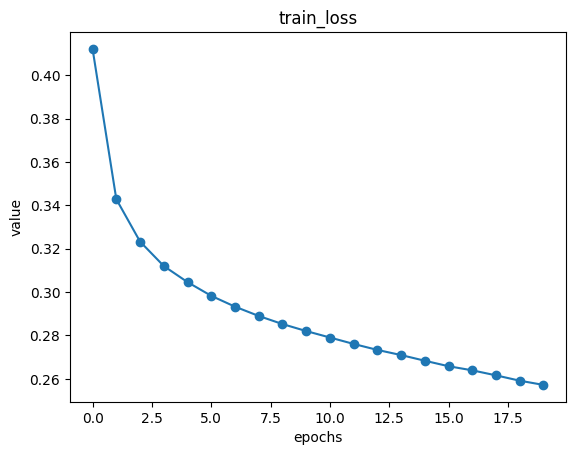

In [23]:
df = pd.DataFrame(train_loss_list)
file_path = '/kaggle/working/train_loss_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(train_loss_list)),train_loss_list, marker='o')
plt.title("train_loss")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/train_loss_plot.png"
plt.savefig(plot_path)

Plotting validation loss

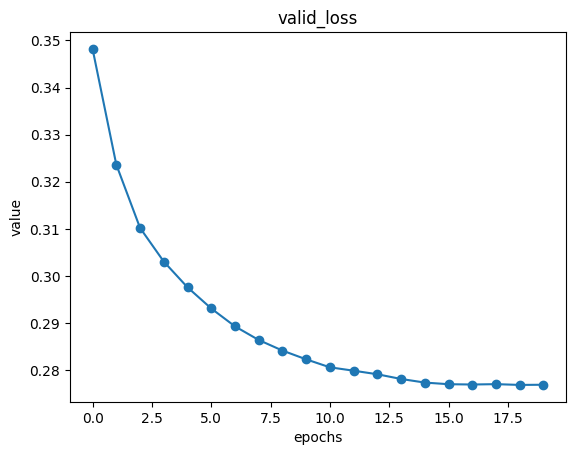

In [24]:
df = pd.DataFrame(valid_loss_list)
file_path = '/kaggle/working/valid_loss_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(valid_loss_list)),valid_loss_list, marker='o')
plt.title("valid_loss")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/valid_loss_plot.png"
plt.savefig(plot_path)

Plotting validation accuracy

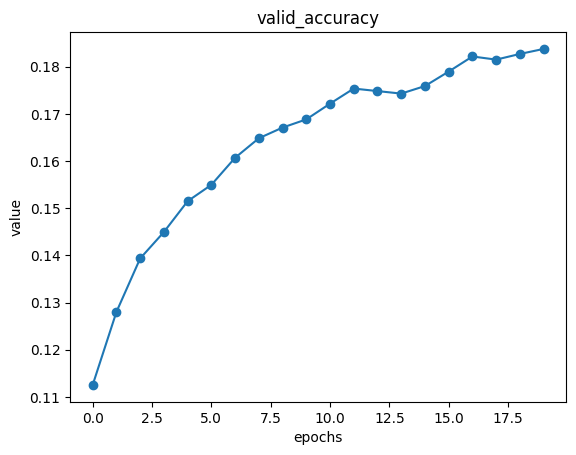

In [25]:
df = pd.DataFrame(accuracy_list)
file_path = '/kaggle/working/accuracy_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(accuracy_list)),accuracy_list, marker='o')
plt.title("valid_accuracy")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/accuracy_plot.png"
plt.savefig(plot_path)

Plotting validation precision

In [26]:
df = pd.DataFrame(precision_list)
file_path = '/kaggle/working/precision_list.xlsx'
df.to_excel(file_path, index=False, header=False)

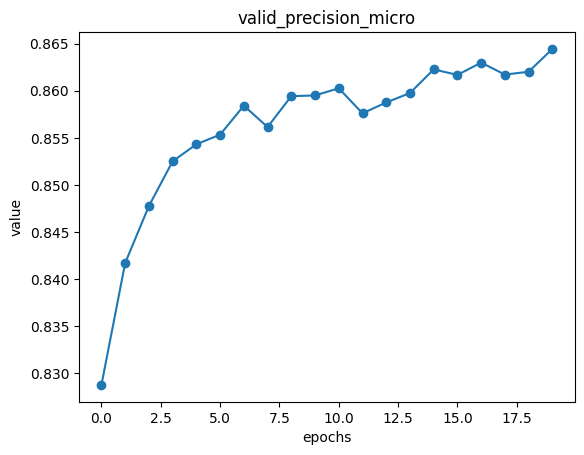

In [27]:
df = pd.DataFrame(precision_micro_list)
file_path = '/kaggle/working/precision_micro_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(precision_micro_list)),precision_micro_list, marker='o')
plt.title("valid_precision_micro")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/precision_micro_plot.png"
plt.savefig(plot_path)

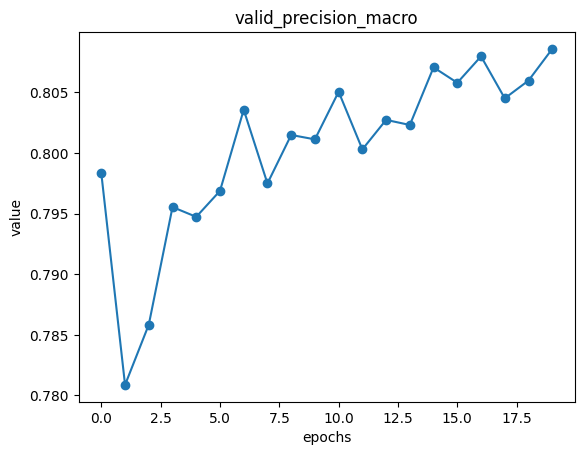

In [28]:
df = pd.DataFrame(precision_macro_list)
file_path = '/kaggle/working/precision_macro_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(precision_macro_list)),precision_macro_list, marker='o')
plt.title("valid_precision_macro")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/precision_macro_plot.png"
plt.savefig(plot_path)

Plotting validation recall

In [29]:
df = pd.DataFrame(recall_list)
file_path = '/kaggle/working/recall_list.xlsx'
df.to_excel(file_path, index=False, header=False)

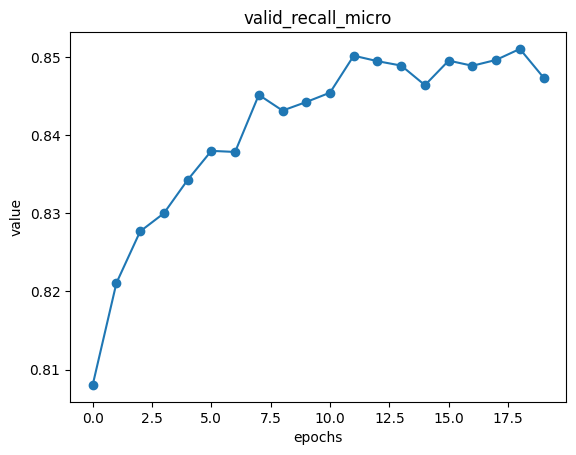

In [30]:
df = pd.DataFrame(recall_micro_list)
file_path = '/kaggle/working/recall_micro_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(recall_micro_list)),recall_micro_list, marker='o')
plt.title("valid_recall_micro")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/recall_micro_plot.png"
plt.savefig(plot_path)

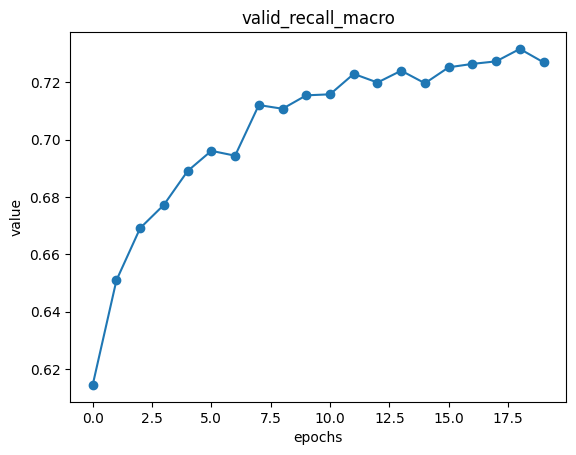

In [31]:
df = pd.DataFrame(recall_macro_list)
file_path = '/kaggle/working/recall_macro_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(recall_macro_list)),recall_macro_list, marker='o')
plt.title("valid_recall_macro")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/recall_macro_plot.png"
plt.savefig(plot_path)

Plotting validation f1_score

In [32]:
df = pd.DataFrame(f1_score_list)
file_path = '/kaggle/working/f1_score_list.xlsx'
df.to_excel(file_path, index=False, header=False)

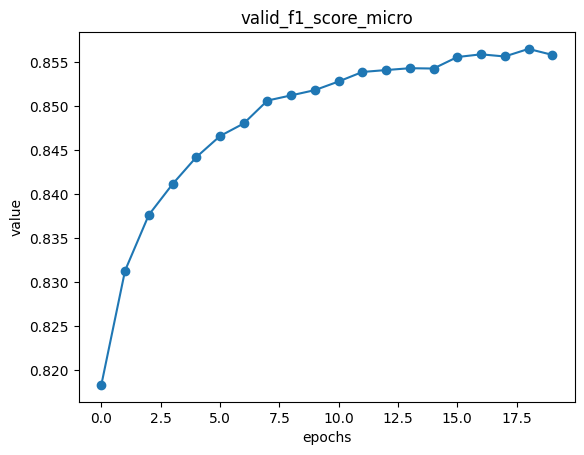

In [33]:
df = pd.DataFrame(f1_score_micro_list)
file_path = '/kaggle/working/f1_score_micro_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(f1_score_micro_list)),f1_score_micro_list, marker='o')
plt.title("valid_f1_score_micro")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/f1_score_micro_plot.png"
plt.savefig(plot_path)

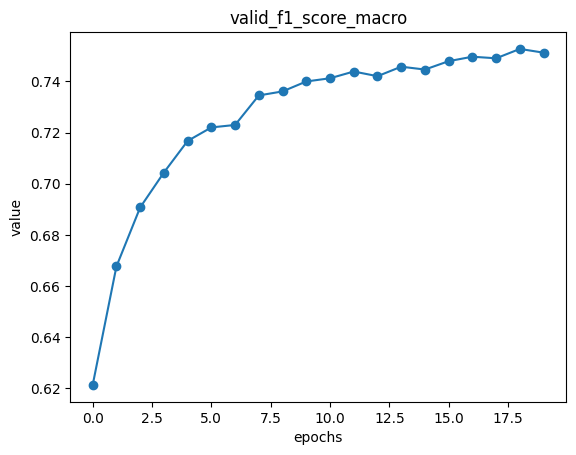

In [34]:
df = pd.DataFrame(f1_score_macro_list)
file_path = '/kaggle/working/f1_score_macro_list.xlsx'
df.to_excel(file_path, index=False, header=False)

plt.plot(np.arange(0,len(f1_score_macro_list)),f1_score_macro_list, marker='o')
plt.title("valid_f1_score_macro")
plt.xlabel("epochs")
plt.ylabel("value")
plot_path = "/kaggle/working/f1_score_macro_plot.png"
plt.savefig(plot_path)